# Double Deep Q-Network

**Environment:** CartPole-v1

**Actions:** 0 to push the cart to the left 
         1 to push the cart to the right.  

To "solve" this puzzle we have to have an average reward of > 195 over 100 consecutive episodes. 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50)

c:\Users\SK\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\SK\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\SK\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[50]

In [2]:
EPISODES = 300
TRAIN_END = 0

def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size():
    return 24

batch_size = batch_size()

nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions

In [4]:
class DoubleDeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.model_target = self.build_model() #Second (target) neural network
        self.update_target_from_model() #Update weights
        self.loss = []

    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu'))
        model.add(keras.layers.Dense(24, activation='relu'))
        model.add(keras.layers.Dense(self.nA, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=self.alpha))
        return model

    def update_target_from_model(self):
        self.model_target.set_weights( self.model.get_weights() )

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: 
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): 
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) 
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst) 
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_target = nst_predict_target[index]
            nst_action_predict_model = nst_predict[index]
            if done == True: 
                target = reward
            else:
                target = reward + self.gamma * nst_action_predict_target[np.argmax(nst_action_predict_model)]
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
 
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)

        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [6]:

dqn = DoubleDeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell.
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #Update the weights after each episode (You can configure this for x steps as well
    dqn.update_target_from_model()
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/300, score: 13.0, e: 1
episode: 1/300, score: 10.0, e: 1
1/1 [==============================] - 0s 16ms/step
episode: 2/300, score: 18.0, e: 0.9229311239742362
1/1 [==============================] - 0s 27ms/step
episode: 3/300, score: 14.0, e: 0.8647077305675338
1/1 [==============================] - 0s 23ms/step
episode: 4/300, score: 25.0, e: 0.7666961448653229
1/1 [==============================] - 0s 13ms/step
episode: 5/300, score: 25.0, e: 0.6797938283326578
1/1 [==============================] - 0s 16ms/step
episode: 6/300, score: 12.0, e: 0.6433260027715241
1/1 [==============================] - 0s 24ms/step
episode: 7/300, score: 10.0, e: 0.6149486215357263
1/1 [==============================] - 0s 21ms/step
episode: 8/300, score: 11.0, e: 0.5848838636585911
1/1 [==============================] - 0s 34ms/step
episode: 9/300, score: 10.0, e: 0.5590843898207511
1/1 [==============================] - 0s 40ms/step
episode: 10/300, score: 14.0, e: 0.5238143793828016
1/1 

In [7]:
#Testing
print('Training complete. Testing started...')
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        #done: CartPole fell.
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209:
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

Training complete. Testing started...
1/1 [==============================] - 0s 32ms/step
episode: 0/164, score: 210.0, e: 0
1/1 [==============================] - 0s 34ms/step
episode: 1/164, score: 210.0, e: 0
1/1 [==============================] - 0s 31ms/step
episode: 2/164, score: 210.0, e: 0
1/1 [==============================] - 0s 31ms/step
episode: 3/164, score: 210.0, e: 0
1/1 [==============================] - 0s 32ms/step
episode: 4/164, score: 210.0, e: 0
1/1 [==============================] - 0s 31ms/step
episode: 5/164, score: 210.0, e: 0
1/1 [==============================] - 0s 30ms/step
episode: 6/164, score: 210.0, e: 0
1/1 [==============================] - 0s 47ms/step
episode: 7/164, score: 210.0, e: 0
1/1 [==============================] - 0s 32ms/step
episode: 8/164, score: 210.0, e: 0
1/1 [==============================] - 0s 44ms/step
episode: 9/164, score: 210.0, e: 0
1/1 [==============================] - 0s 31ms/step
episode: 10/164, score: 210.0, e: 0
1/1 

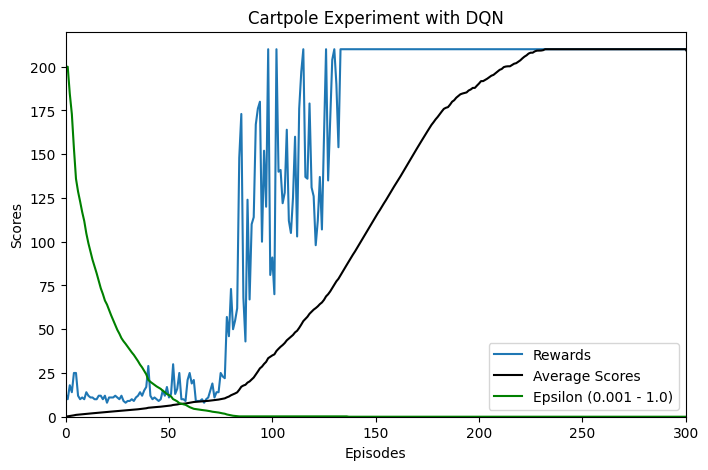

In [8]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.figure(figsize=(8, 5))
plt.plot(rewards, label='Rewards')
plt.plot(rolling_average, color='black', label='Average Scores')
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-', label='Epsilon (0.001 - 1.0)')
plt.title("Cartpole Experiment with DQN")
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.xlim((0, EPISODES))
plt.ylim((0, 220))
plt.legend()
plt.show()


**Reference**  
Van Hasselt, H., Guez, A., & Silver, D. (2016, February). Deep Reinforcement Learning with Double Q-Learning. In AAAI (Vol. 2, p. 5)